<a href="https://colab.research.google.com/github/yasararafath-s/Sentiment_analysis_imdb_lstm/blob/main/Sentiment_Analysis_of_IMDB_Movie_Reviews_Using_LSTM_pytorch_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of IMDB Movie Reviews Using LSTM_pytorch_1

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.datasets import imdb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Load and preprocess data
max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

def pad_sequences(data, maxlen):
    return [seq[:maxlen] + [0] * (maxlen - len(seq)) if len(seq) < maxlen else seq[:maxlen] for seq in data]

x_train = pad_sequences(x_train, max_len)
x_test = pad_sequences(x_test, max_len)

# Data Preview
print("Data Sample (as integers):", x_train[0])
print("Label Sample:", y_train[0])

Data Sample (as integers): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [3]:
# PyTorch Dataset and DataLoader
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

train_dataset = IMDBDataset(x_train, y_train)
test_dataset = IMDBDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
# Calculate class weights
class_counts = Counter(y_train)
class_weights = torch.tensor([class_counts[0] / len(y_train), class_counts[1] / len(y_train)], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)

In [5]:
# Define the PyTorch Model with Bidirectional LSTM and Dropout
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        x = self.dropout(hidden)
        x = self.fc(x)
        return self.sigmoid(x)

model = LSTMModel(max_features, 128, 64).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

In [6]:
# Training the Model
train_loss_values = []
val_loss_values = []

def train_and_validate_model():
    for epoch in range(15):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_values.append(train_loss)

        # Validation Loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        val_loss_values.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

In [7]:
# Evaluation and Metrics
all_predictions = []
all_labels = []

def evaluate_model():
    model.eval()
    global all_predictions, all_labels
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs.squeeze() > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Training and Evaluation
train_and_validate_model()
evaluate_model()

Epoch 1, Train Loss: 0.6834, Validation Loss: 0.6708
Epoch 2, Train Loss: 0.6027, Validation Loss: 0.5577
Epoch 3, Train Loss: 0.5111, Validation Loss: 0.6551
Epoch 4, Train Loss: 0.5208, Validation Loss: 0.4860
Epoch 5, Train Loss: 0.4326, Validation Loss: 0.4655
Epoch 6, Train Loss: 0.5415, Validation Loss: 0.5444
Epoch 7, Train Loss: 0.6355, Validation Loss: 0.5761
Epoch 8, Train Loss: 0.5719, Validation Loss: 0.6708
Epoch 9, Train Loss: 0.5881, Validation Loss: 0.4807
Epoch 10, Train Loss: 0.4342, Validation Loss: 0.4735
Epoch 11, Train Loss: 0.3429, Validation Loss: 0.3991
Epoch 12, Train Loss: 0.2954, Validation Loss: 0.3714
Epoch 13, Train Loss: 0.2553, Validation Loss: 0.3614
Epoch 14, Train Loss: 0.2288, Validation Loss: 0.3755
Epoch 15, Train Loss: 0.2040, Validation Loss: 0.3750
Accuracy: 0.8595, Precision: 0.8402, Recall: 0.8879, F1 Score: 0.8634


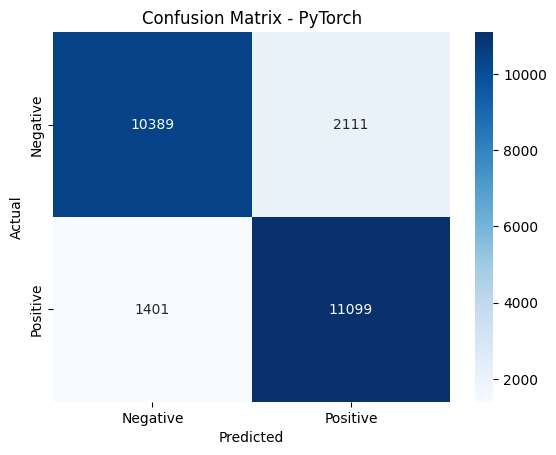

In [8]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - PyTorch')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_pytorch_fixed.png')
plt.show()

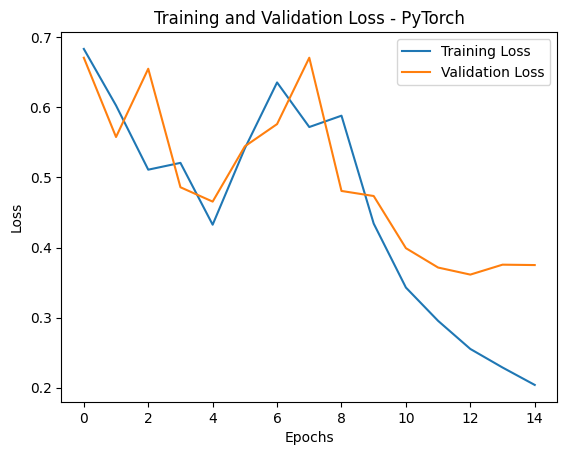

In [9]:
# Plot Loss Curves
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss - PyTorch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot_pytorch_fixed.png')
plt.show()

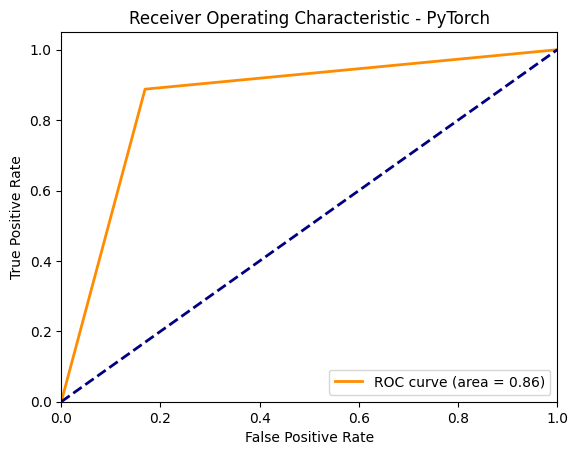

In [12]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - PyTorch')
plt.legend(loc="lower right")
plt.show()

In [13]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.83      0.86     12500
         1.0       0.84      0.89      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

